# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.



<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/adriangb/scikeras/blob/master/notebooks/Basic_Usage.ipyn">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/adriangb/scikeras/blob/master/notebooks/Basic_Usage.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

### Table of contents

* [Data](#Data)
* [Define Model](#Model)
* [Training](#Training)
* [Explore Results](#Explore-Results)

Install SciKeras

In [ ]:
!python -m pip install git+https://github.com/adriangb/scikeras.git@master

Silence TensorFlow warnings to keep output succint.

In [54]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [55]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [64]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Define Keras Model

We will be defining a very simple autencoder.

In [65]:
from tensorflow import keras
from tensorflow.keras import layers


# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder_model = keras.Model(input_img, decoded)

# This model maps an input to its encoded representation
encoder_model = keras.Model(input_img, encoded)

# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder_model.layers[-1]
# Create the decoder model
decoder_model = keras.Model(encoded_input, decoder_layer(encoded_input))


In [66]:
from scikeras.wrappers import BaseWrapper


class BaseWrapperNoVal(BaseWrapper):

    def _validate_data(self, X, y=None, reset: bool = False):
        return X, y


compile_params = {"optimizer": "adam", "loss": "binary_crossentropy"}
fit_params = {"epochs": 50, "batch_size": 256, "shuffle": True}

autoencoder = BaseWrapperNoVal(model=autoencoder_model, **compile_params, **fit_params)
encoder = BaseWrapperNoVal(model=encoder_model, **compile_params, **fit_params)
decoder = BaseWrapperNoVal(model=decoder_model, **compile_params, **fit_params)

## Train

To train the model, we pass the input images as both the features and the target.

In [67]:
autoencoder.fit(x_train, x_train)

Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.2752
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1690
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1430
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1279
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1174
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1105
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1057
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1021
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0995
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0976
Epoch 11/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0963
Epoch 12/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0955
Epoch 13/50
235/235 [====

BaseWrapperNoVal(
	model=<tensorflow.python.keras.engine.functional.Functional object at 0x14fb31a00>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=256
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
)

For our encoder layer, we need to build the model, but we do not necessarily want to fit it to any data (we are re-using the weights from `autoencoder`). SciKeras allows this by calling `fit(X=None, y=None)`.

In [68]:
_ = encoder.fit(X=None, y=None)

Now we can use the encoder to encode our data!

In [69]:
encoded_imgs = encoder.predict(x_test)
encoded_imgs.shape

40/40 [==============================] - 0s 739us/step


(10000, 32)

We will now do the same for the decoder:

In [70]:
decoder.fit(X=None, y=None)
decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs.shape

40/40 [==============================] - 0s 2ms/step


(10000, 784)

Now let's compare our inputs to lossy decoded outputs:

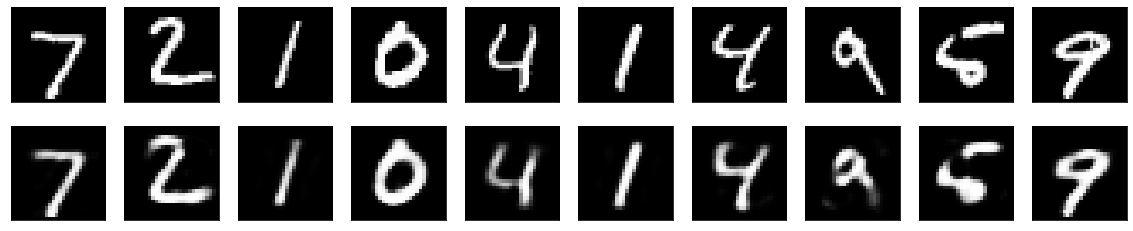

In [71]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()